In [1]:
import torch
import torchvision.transforms as transforms 
import torch.nn.init
from torchsummary import summary as summary_
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets

In [2]:
#Train data 받아오기

path_dir = 'LJH/data/product_data/train/Item-Parse_f' #Parse 폴더에서 파일명 불러오기
file_list_train = os.listdir(path_dir)

In [3]:
TRAIN_SIZE = len(file_list_train)
label = [0 for i in range(TRAIN_SIZE)] #list형
path_dir_img = 'train/'

def make_file_list():
    #train_img_list = [0 for i in range(len(file_list_train))]
    train_img_list = [0 for i in range(TRAIN_SIZE)]
    cnt = 0
    #for i in file_list_train:
    for i in range(TRAIN_SIZE):
    
        with open(path_dir +'/'+ file_list_train[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_train[cnt].split('.')[0]
        train_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label[cnt] = category

        cnt+=1

    return train_img_list


In [4]:
class ImageTransform():

    def __init__(self):
        
        self.data_transform = transforms.Compose([
            #transforms.CenterCrop(720),
            #transforms.Resize(256),
            transforms.ToTensor(),
        ])
        

    def __call__(self, img):
        return self.data_transform(img)

In [5]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label[index]

        return img_transformed,img_label

In [6]:
train_img_list=make_file_list()

In [7]:
train_dataset = Img_Dataset(file_list=train_img_list,
                            transform=ImageTransform())

In [8]:
train_dataloader = data.DataLoader(train_dataset,
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True)
print('Dataloader created')

Dataloader created


In [9]:
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

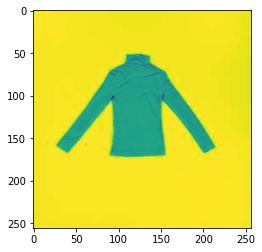

In [10]:
plt.imshow(images[0][3][0])
plt.show() 

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
class Alexnet(torch.nn.Module): 
    def __init__(self): 
        super(Alexnet, self).__init__() 
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(0.2),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, 5),
        )
        
#    def init_bias(self):
#        for layer in self.net:
#            if isinstance(layer, nn.Conv2d):
#                nn.init.normal_(layer.weight, mean=0, std=0.01)
#                nn.init.constant_(layer.bias, 0)
#        
#        nn.init.constant_(self.net[4].bias, 1)
#        nn.init.constant_(self.net[10].bias, 1)
#        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        

In [13]:
from torchsummary import summary as summary_
DEVICE_IDS = [0,1]
model = Alexnet().to(device)
summary_(model,(3,256,256),batch_size = 128)
Alexnet = torch.nn.parallel.DataParallel(Alexnet, device_ids=DEVICE_IDS)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 63, 63]          23,296
         LeakyReLU-2          [128, 64, 63, 63]               0
         MaxPool2d-3          [128, 64, 31, 31]               0
            Conv2d-4         [128, 192, 31, 31]         307,392
         LeakyReLU-5         [128, 192, 31, 31]               0
         MaxPool2d-6         [128, 192, 15, 15]               0
            Conv2d-7         [128, 384, 15, 15]         663,936
         LeakyReLU-8         [128, 384, 15, 15]               0
            Conv2d-9         [128, 256, 15, 15]         884,992
        LeakyReLU-10         [128, 256, 15, 15]               0
           Conv2d-11         [128, 256, 15, 15]         590,080
        LeakyReLU-12         [128, 256, 15, 15]               0
        MaxPool2d-13           [128, 256, 7, 7]               0
AdaptiveAvgPool2d-14           [128, 25

/home/rpc/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [15]:
total_batch = len(train_dataloader)
for epoch in range(10): 
    avg_cost = 0 
    cnt = 0
    
    for X, Y in train_dataloader: 
        X = X.to(device) 
        Y = Y.to(device) 
        
        optimizer.zero_grad() 
        hypothesis = model(X) 
        cost = criterion(hypothesis, Y) 
        cost.backward() 
        optimizer.step() 
       
        avg_cost += cost / total_batch
           
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.700542927
[Epoch:    2] cost = 0.441431016
[Epoch:    3] cost = 0.354880601
[Epoch:    4] cost = 0.307719201
[Epoch:    5] cost = 0.278242379
[Epoch:    6] cost = 0.260138452
[Epoch:    7] cost = 0.242898792
[Epoch:    8] cost = 0.228259012
[Epoch:    9] cost = 0.217419729
[Epoch:   10] cost = 0.204460621


In [16]:
path_dir = 'LJH/data/product_data/test/Item-Parse_f'
path_dir_img = 'test'
file_list_test = os.listdir(path_dir)
Test_size = len(file_list_test)
#label_test = [0 for i in range(len(file_list_test))] #list형
label_test = [0 for i in range(Test_size)] 
def make_file_list_test():
    #test_img_list = [0 for i in range(len(file_list_test))]
    test_img_list = [0 for i in range(Test_size)]
    cnt = 0
    #for i in file_list_test:
    for i in range(Test_size):
    
        with open(path_dir +'/'+ file_list_test[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_test[cnt].split('.')[0]
        test_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label_test[cnt] = category

        cnt+=1

    return test_img_list

In [17]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label_test[index]

        return img_transformed,img_label

In [18]:
test_img_list=make_file_list_test()

In [19]:
"""from torchvision.transforms import ToTensor
X_test = torch.empty(0,3,256,256)
cnt_img = 0

for j in test_img_list:
    image = Image.open(test_img_list[cnt_img])
    #image = image.crop((0,280,720,1000))
    #image = image.resize((256, 256))
    data = ToTensor()(image).unsqueeze(0)
    X_test =torch.cat([X_test,data],dim=0)
    cnt_img += 1
    if cnt_img % 1000 == 0:
        print(cnt_img)"""

'from torchvision.transforms import ToTensor\nX_test = torch.empty(0,3,256,256)\ncnt_img = 0\n\nfor j in test_img_list:\n    image = Image.open(test_img_list[cnt_img])\n    #image = image.crop((0,280,720,1000))\n    #image = image.resize((256, 256))\n    data = ToTensor()(image).unsqueeze(0)\n    X_test =torch.cat([X_test,data],dim=0)\n    cnt_img += 1\n    if cnt_img % 1000 == 0:\n        print(cnt_img)'

In [20]:
#print(X_test.shape)

In [21]:
#Y_test = torch.tensor(label_test)

In [22]:
test_dataset = Img_Dataset(file_list=test_img_list, transform=ImageTransform())


In [23]:
test_dataloader = data.DataLoader(test_dataset,
                                   batch_size=32,
                                   shuffle=False,
                                   drop_last=True)

In [24]:
print(type(test_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [25]:
#Testing classification accuracy for individual classes.
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
arr = [[0]*5 for i in range(5)]
with torch.no_grad():
    for datas in test_dataloader:
        images, labels = datas[0].to(device), datas[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(32):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            arr[label][predicted[i]] += 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

for i in range(5):
    print('Accuracy of %d : %2d %%' % (
        i, 100 * class_correct[i] / class_total[i]))

print('total Accurarcy : %2d %%' %(100 * correct / total))
print()
print('Num  of total : %2d / %2d  ' %(correct, total))
for i in range(5):
    print('Num of %d : %2d / %2d' % (
        i, class_correct[i], class_total[i]))

Accuracy of 0 : 95 %
Accuracy of 1 : 79 %
Accuracy of 2 : 92 %
Accuracy of 3 : 98 %
Accuracy of 4 : 100 %
total Accurarcy : 93 %

Num  of total : 7364 / 7904  
Num of 0 : 23 / 24
Num of 1 : 706 / 889
Num of 2 : 3874 / 4176
Num of 3 : 2681 / 2735
Num of 4 : 80 / 80


In [26]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

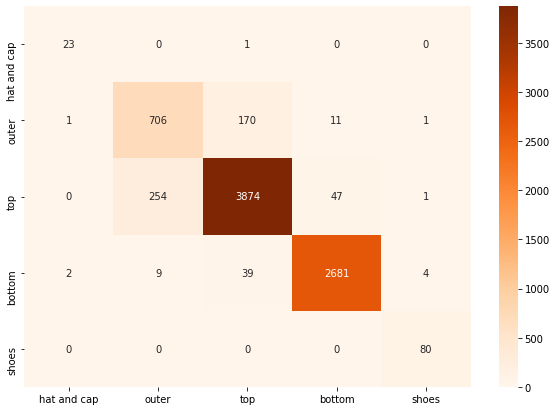

In [27]:
classes = ["hat and cap", "outer", "top", "bottom","shoes"]
df_cfm = pd.DataFrame(arr, index = classes, columns = classes)
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True, cmap='Oranges', fmt='g')

In [28]:
# 0:hat 1:outer 2:top 3:bottom 4: shoes